In [1]:
import os
import site
import sqlite3
import sys
from time import sleep

import logzero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import SARIMAX, VAR, acf, adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from tqdm import tqdm
from tqdm.notebook import tqdm
from yaml import dump, load, safe_load

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
plt.rcParams["figure.figsize"] = 30, 25
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [4]:
log_path = "logs/"
log_file = "ts_arima.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [5]:
sys.path.append("../../sql")
import queries

sys.path.append("../source")
from ts_tools import gen_arima_params

In [6]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_paths"]["db_path"]

city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "-" + state + ".db"

db_table1 = configs["table_names"]["db_table1"]
db_table2 = configs["table_names"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [7]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

In [8]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['91708']


In [9]:
zipcode_index = 0
params = {"zipcode": distinct_zipcodes[zipcode_index]}

select_nsr_rows = f"""
SELECT date_time,
-- year, month, day, 
-- zipcode,
-- Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature,
Relative_Humidity,
Precipitable_Water,
-- Wind_Direction,
Wind_Speed
from nsrdb
where zipcode = :zipcode
-- and not (month = 2 and day = 29)
-- and year = 2000
;
"""

df = pd.read_sql(
    select_nsr_rows,
    conn,
    params=params,
    index_col="date_time",
    parse_dates=["date_time"],
)

df.sort_index(axis=0, inplace=True)
columns = df.columns.tolist()
# df.head(5)

In [10]:
df_rsm = df.resample("M").mean().reset_index(drop=False)
df_rsm.set_index("date_time", inplace=True)
# df_rsm

In [11]:
# df_diff = df_rsm.diff(periods=12).dropna()

df_diff = df_rsm.copy()
for column in columns:
    df_diff[column] = diff(df_diff[column], 1, 1, 12)

df_diff.dropna(inplace=True)

# df_diff.head(12)2)

In [12]:
df_diff_r = df_diff[:240]
# df_diff_r

In [25]:
order_list = gen_arima_params(p_rng=(3, 7), d_rng=(0, 3), q_rng=(3, 7))
# order_list = gen_arima_params()

Order list length: 100


In [28]:
def ARIMA_optimizer(series, order_list):
    """ """

    results = []

    for order in tqdm(order_list):
        try:
            model = ARIMA(series, order=order, ).fit()
            # model = ARIMAX(series, order=order, simple_differencing=False).fit(disp=False)
        except:
            print("exception occured")
            continue

        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ["(p, d, q)", "AIC"]
    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

    return result_df

In [29]:
results = ARIMA_optimizer(df_rsm[columns[1]], order_list)

  0%|          | 0/100 [00:00<?, ?it/s]

In [35]:
results.head()

,"(p, d, q)",AIC
0,"(5, 1, 6)",2782.528998
1,"(3, 1, 7)",2783.193731
2,"(5, 1, 7)",2783.502191
3,"(4, 1, 7)",2783.987658
4,"(6, 1, 5)",2784.777504


In [38]:
results.iloc[0]['(p, d, q)']

(5, 1, 6)

In [64]:
def arima_model(series, p=0, d=0, q=0, s=0, num_fc=1, summary=False, forecast=False):
    """
    Takes an irradiance related series and fits an ARIMA(p, d, q) model.
    Returns a number of forecasts as specified by num_forecasts or
    a fit model is returned if forecast is not set.
    """

    start = len(series)
    end = start + num_fc

    model = ARIMA(
        series,
        order=(p, d, p),
        seasonal_order=(0, 0, 0, s),
        enforce_stationarity=True,
        trend="n",
        # freq="M",
    ).fit()

    if summary:
        print(model.summary())

    if forecast:
        forecast = model.predict(start=start, end=end)
        return forecast

    return model

In [148]:
model = arima_model(df_rsm.iloc[:252][columns[1]], *results.iloc[0]['(p, d, q)'], s=0, summary=True)

                               SARIMAX Results                                
Dep. Variable:                    DNI   No. Observations:                  252
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -1255.054
Date:                Mon, 26 Jul 2021   AIC                           2532.107
Time:                        18:51:00   BIC                           2570.887
Sample:                    01-31-1998   HQIC                          2547.713
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0522      0.116      0.448      0.654      -0.176       0.280
ar.L2          1.1677      0.055     21.091      0.000       1.059       1.276
ar.L3         -0.2623      0.132     -1.987      0.0

In [67]:
# model.plot_diagnostics()

In [170]:
forecast = arima_model(df_rsm.iloc[:252][columns[1]], *results.iloc[0]['(p, d, q)'], s=0, num_fc=23, forecast=True)
# forecast = arima_model(df_rsm.iloc[:240][columns[1]], p=1, d=1, q=1, num_fc=1, forecast=True)

In [171]:
# display(df_rsm.iloc[237:240])
# df_rsm.iloc[:252][columns[1]]

In [172]:
# forecast[12:]

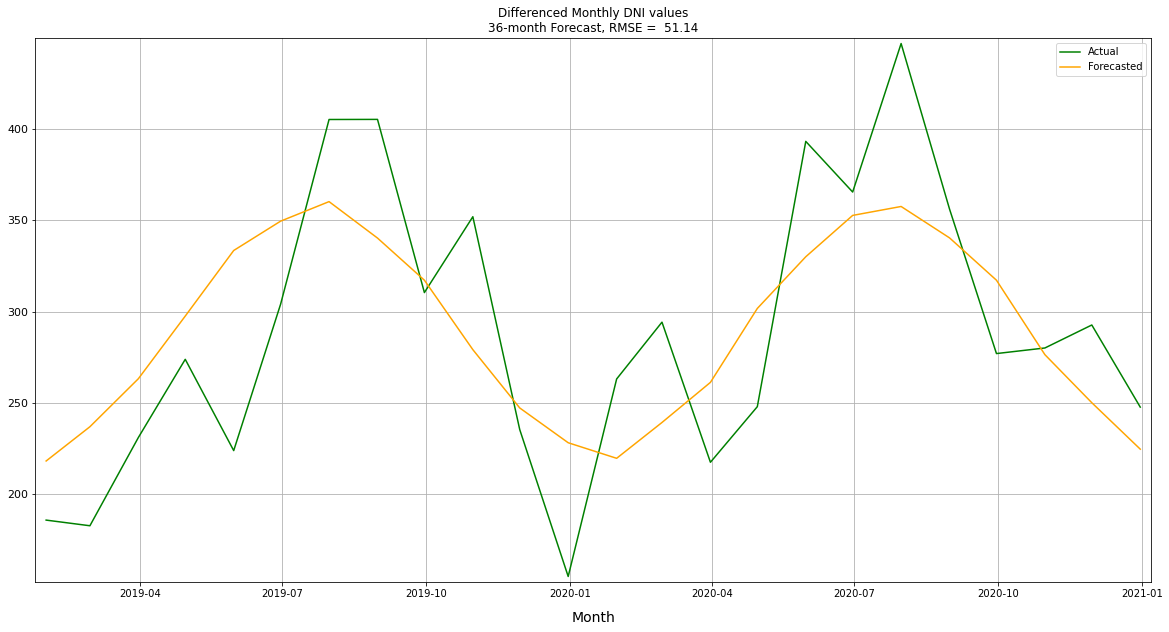

In [176]:
actual = df_rsm.iloc[252:][columns[1]]

rmse = np.sqrt(np.mean((actual - forecast) ** 2))

fig, ax = plt.subplots(figsize=(20, 10))

# ax.plot(df_rsm.iloc[:252][columns[1]], label="Original", color="blue")
ax.plot(actual, label="Actual", color="green")
ax.plot(forecast, label="Forecasted", color="orange")

ax.set_xlabel("Month")

ax.set_title(
    f"Differenced Monthly {columns[1]} values\n" + f"{len(forecasts)}-month Forecast, RMSE = {rmse: .2f}"
)

ax.grid()
ax.legend();

In [106]:
df_rsm[columns[1]][252:]

date_time
2019-01-31    185.975806
2019-02-28    182.882440
2019-03-31    231.193548
2019-04-30    273.993056
2019-05-31    224.024194
2019-06-30    304.151389
2019-07-31    405.284946
2019-08-31    405.340054
2019-09-30    310.533333
2019-10-31    352.060484
2019-11-30    235.525000
2019-12-31    155.119624
2020-01-31    263.241935
2020-02-29    294.339080
2020-03-31    217.635753
2020-04-30    248.077778
2020-05-31    393.302419
2020-06-30    365.570833
2020-07-31    446.870968
2020-08-31    356.186828
2020-09-30    277.145833
2020-10-31    280.205645
2020-11-30    292.790278
2020-12-31    247.826613
Name: DNI, dtype: float64

In [69]:
actual

date_time
2020-01-31     2.090054
2020-02-29     3.837438
2020-03-31    -3.399194
2020-04-30     0.970833
2020-05-31    27.194892
2020-06-30     0.436111
2020-07-31    11.116935
2020-08-31   -60.536290
2020-09-30   -94.718056
2020-10-31   -39.279570
2020-11-30     8.327778
2020-12-31    11.075269
Name: Clearsky_DNI, dtype: float64